In [31]:
import numpy as onp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import scipy.optimize


In [32]:
pscale = 0.156

In [35]:
def create_separation_data(true_signal, std, plot = False, exposure_time = 3600):
    '''
    true_signal is in micro arc seconds, 
    std is the standard deviation of the separation error in pix
    exposure time is in seconds (used for getting 3 years of data)
    '''
    # calculate time vector
    t_len = int((3*365*24*60*60) / exposure_time)
    tt = onp.linspace(0,t_len, t_len+1)
    
    # convert true_signal from mAS to pix
    amplitude = true_signal * (2/pscale)
    
    # generate data
    frequency = (1/(t_len/3))
    planet_signal = true_signal*onp.sin(2*onp.pi*frequency*tt)
    noise = onp.random.normal(loc = 0, scale = std, size = t_len+1)
    noisy_signal = planet_signal+noise 
    
    # plotting code
    if plot == True:
        plt.figure(figsize = (8,6))
        plt.scatter(tt, noisy_signal, alpha = 0.1, marker = 'x', color = 'tab:blue', label = 'Estimated Separation')
        plt.plot(tt, planet_signal, ls = '--', color = 'red', label = 'True Signal')
        plt.xlabel('Epoch', fontsize = 16)
        plt.ylabel('Measured Separation (pix)', fontsize = 16)
        plt.title('Simulated Seperation Error', fontsize = 20)
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)
        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)

        
    return noisy_signal, amplitude, frequency, tt

def my_sin(x0, tt, data):
    amplitude = x0[0]
    frequency = x0[1]
    return amplitude*onp.sin(2*onp.pi*frequency*tt) - data

def fit_signal(true_signal, std, exposure_time = 3600, relative_error = False):
    noisy_signal, true_amplitude, true_frequency, tt = create_separation_data(true_signal, std, exposure_time)

    # initial guess is true signal 
    x0 = [true_amplitude, true_frequency]
    #x0 = [0,0]  # for testing blind
    est_amplitude, est_frequency = scipy.optimize.leastsq(my_sin, x0, args = (tt, noisy_signal), xtol = 1e-12, ftol = 1e-12)[0]
    est_amplitude *= 2/pscale  # there is some scaling error somewhere
    
    if relative_error == False:
        return est_amplitude, est_frequency
    else:
        return est_amplitude/true_amplitude, est_frequency/true_frequency
    
    
    
    

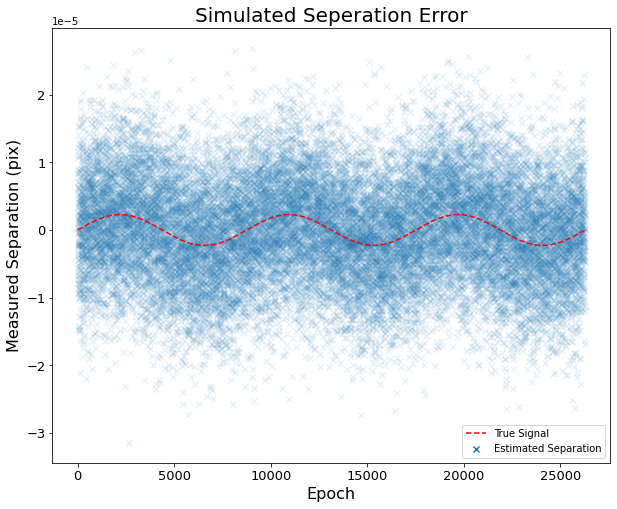

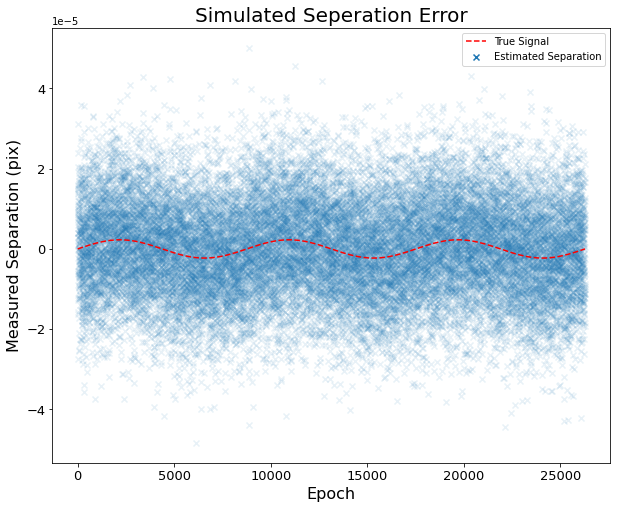

In [23]:
alpha_cenAB_sig = 2.278e-6 #uAS
cygni_61AB_sig = 0.4e-6  #uAs

best_results = 1* 5.88e-6 # best std achieved

data = create_separation_data(alpha_cenAB_sig, best_results*1.25, plot = True)
data = create_separation_data(alpha_cenAB_sig, best_results*2, plot = True)

In [36]:
%%time
fit = fit_signal(alpha_cenAB_sig, best_results, relative_error = True)
print(fit)

(1.0394576492242207, 1.0057187464590942)
CPU times: user 20.7 ms, sys: 9 µs, total: 20.7 ms
Wall time: 19.2 ms


In [144]:
signal_range = 10**(onp.linspace(-7, -5.9, 100))
std_range = 10**(onp.linspace(-5.3, -4.20, 100))


amp_matrix = onp.zeros((100,100)) # y axis is seems
freq_matrix = onp.zeros((100,100)) # x axis

for k in tqdm(range(3)):
    for i in tqdm(range(100)):
        for j in range(100):
            amp, freq = fit_signal(signal_range[i], std_range[j], relative_error = True)
            amp_matrix[i,j] += amp
            freq_matrix[i,j] += freq

amp_matrix  /= 3
freq_matrix /= 3

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

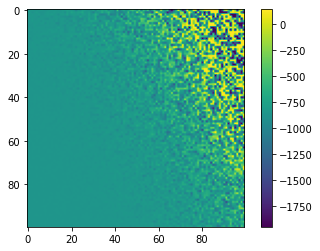

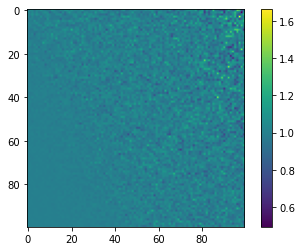

In [75]:

plt.imshow(amp_matrix)
plt.colorbar()
std = onp.std(amp_matrix)
new_mat = amp_matrix
new_mat[new_mat > std] = std
new_mat[new_mat < - std] = -std
plt.imshow(amp_matrix)

plt.figure()
plt.imshow(freq_matrix)
plt.colorbar()



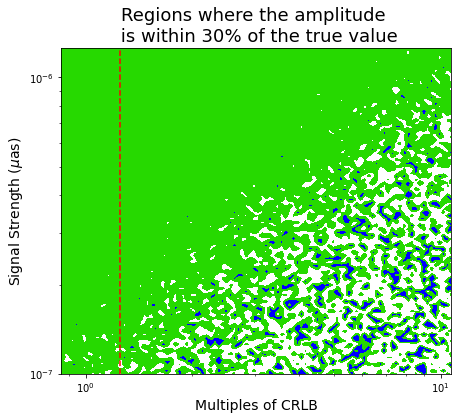

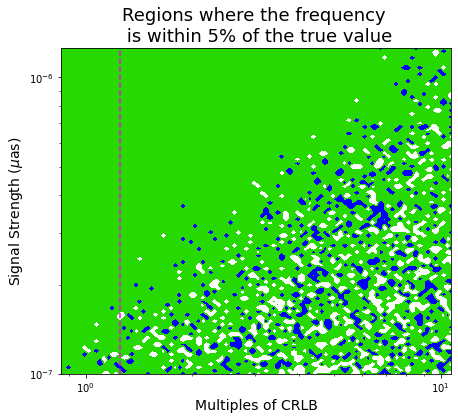

In [282]:

plt.figure(figsize = (7,6))
plt.contourf( std_range/5.88e-6, signal_range, amp_matrix, vmin = -5, vmax = 1.5, levels = [-100,0.7,1.3], cmap = 'brg')
#plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Multiples of CRLB', fontsize = 14)
plt.ylabel('Signal Strength ($\mu$as)', fontsize = 14)
plt.title('Regions where the amplitude \n is within 30% of the true value', fontsize = 18)
plt.vlines(1.25, signal_range[0], signal_range[-1], color = 'red', ls = '--')

test_mat = freq_matrix
test_mat[test_mat > 1.05] = 2
test_mat[test_mat < 0.95] = 0

plt.figure(figsize = (7,6))
plt.contourf( std_range/5.88e-6, signal_range, freq_matrix, vmin = -5, vmax = 1.5, levels = [-100,0.95,1.05], cmap = 'brg')
#plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Multiples of CRLB', fontsize = 14)
plt.ylabel('Signal Strength ($\mu$as)', fontsize = 14)
plt.title('Regions where the frequency \n is within 5% of the true value', fontsize = 18)
plt.vlines(1.25, signal_range[0], signal_range[-1], color = 'magenta', ls = '--')

In [286]:
b = onp.abs(amp_matrix-1)
c = onp.log10(b)
c[c<-0.5] = -0.5

d = onp.abs(freq_matrix -1)

In [141]:
print(onp.shape(signal_range))

(100,)


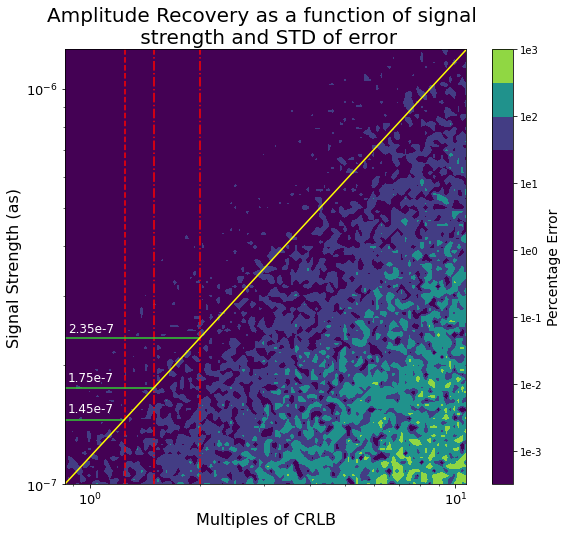

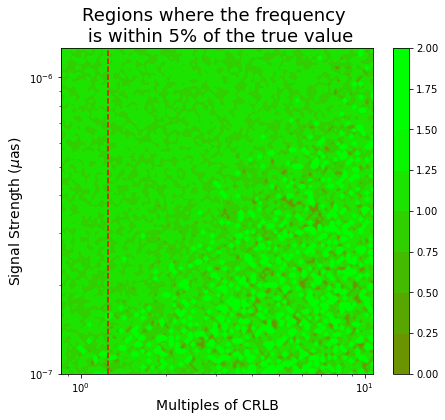

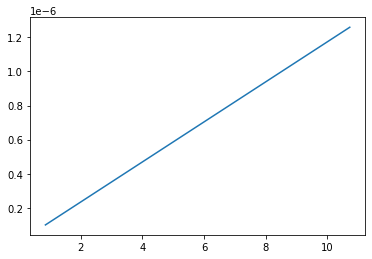

In [316]:
plt.figure(figsize = (9,8))
plt.contourf( std_range/5.88e-6, signal_range, onp.log10(b)*100, vmin = -0.52*100, levels = 12)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(['1e-3', '1e-2', '1e-1','1e0','1e1','1e2','1e3'])
cbar.set_label('Percentage Error', fontsize = 14)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Multiples of CRLB', fontsize = 16)
plt.ylabel('Signal Strength (as)', fontsize = 16)
plt.title('Amplitude Recovery as a function of signal \n strength and STD of error', fontsize = 20)
plt.vlines(1.25, signal_range[0], signal_range[-1], color = 'red', ls = '--')
plt.vlines([1.5,2], signal_range[0], signal_range[-1], color = 'red', ls = '-.')
plt.hlines([2.35e-7,1.75e-7,1.45e-7],0,[2,1.5,1.25], color = 'limegreen')
plt.annotate('2.35e-7', (0.87, 2.42e-7), color = 'white', fontsize = 12)
plt.annotate('1.75e-7', (0.87, 1.82e-7), color = 'white', fontsize = 12)
plt.annotate('1.45e-7', (0.87, 1.52e-7), color = 'white', fontsize = 12)



plt.plot(std_range/5.88e-6, signal_range, color = 'yellow')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)


# test_mat = freq_matrix
# test_mat[test_mat > 1.05] = 2
# test_mat[test_mat < 0.95] = 0

plt.figure(figsize = (7,6))
plt.contourf( std_range/5.88e-6, signal_range, freq_matrix, vmin = -5, vmax = 1.5, cmap = 'brg')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Multiples of CRLB', fontsize = 14)
plt.ylabel('Signal Strength ($\mu$as)', fontsize = 14)
plt.title('Regions where the frequency \n is within 5% of the true value', fontsize = 18)
plt.vlines(1.25, signal_range[0], signal_range[-1], color = 'red', ls = '--')

plt.figure()
plt.plot(std_range/5.88e-6, signal_range)


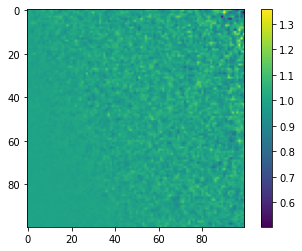

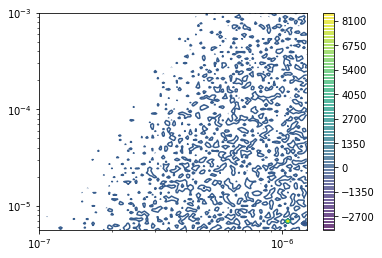

In [183]:
from scipy.ndimage import gaussian_filter

plt.imshow(gaussian_filter(freq_matrix, 0.5))
plt.colorbar()

plt.figure()
plt.contour(signal_range, std_range, amp_matrix, levels = 100)#, vmin = 0.7, vmax = 1.3)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

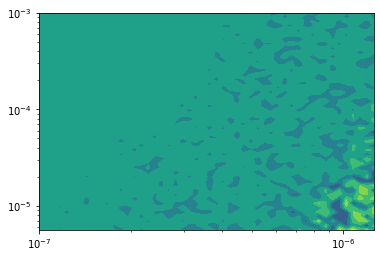

In [150]:

plt.figure()
plt.contourf(signal_range, std_range, amp_matrix)
#plt.colorbar()
plt.xscale('log')
plt.yscale('log')